$$ y_{in} = F_{act}((Im+n_{in} W_{in}) + bias) $$
$$ Im^* = F_{act}(y_{in} W_{in}^T) + n_{out} $$

$$ Cost = \sqrt{\langle|Im-Im^*|\rangle} + \lambda \langle r \rangle $$

In [35]:
#Dependencies
import os
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr
import utils.animutils as aniu

#code to reload
#import imp
#imp.reload(plu)

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [ ]:
#parameters for sweep
#network params
lambdas = [0,1e-5,1e-4,1e-3]
models = ['tanh','relu','sigmoid','linear']
compressions = np.arange(1,20,5)
patchsizes = [12,16]
batchsizes = [10,100,1000]
#training params
learning_rates = [0.05,0.01]
batchsize = 100
iterations = 10000
epochs = 5

In [74]:
#Load in images 
def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        #normalize=True,
        normalize_im = True,
        normalize_patch = False,
        invert_colors = False,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)


def check_n_load_ims(psz):
    try:
        vhims
    except NameError:
        vhims, loadedpatchsize = loadimages(patchsize)

    if(patchsize != loadedpatchsize):
        vhims, loadedpatchsize = loadimages(patchsize)

    print("Images Loaded.")

    #params of images
    imxlen = len(vhims.images[0,0,:])
    imylen = len(vhims.images[0,:,0])
    nimages = len(vhims.images[:,0,0])

    nimstrained = batchsize * iterations

    if(nimstrained > nimages):
        print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
    else:
        print('Training',nimstrained,'out of',nimages,'total image patches.')

    #show an example image
    #plt.imshow(vhims.images[100],cmap='gray',interpolation='none')
    #plt.colorbar()
    
    return(vhimgs, psz, imxlen, imylen, nimages)

Images Loaded.
Training 1000000 out of 4685824 total image patches.


In [ ]:

#run our param sweep
#for patchsize in patchsizes:
#    vhimgs, psz, imxlen, imylen, nimages = check_n_load_ims(patchsize)
    

In [89]:
nneurons = np.int(imxlen*imylen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')
savefolder = str('c/actfun_'+model_type+'/neurons_'+str(nneurons)+'/noise_in_'+str(noisexsigma)+'_out_'+str(noisersigma)+'_lambda_'+str(lamb)+'/')
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

#setup our graph
tf.reset_default_graph()

#input images
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen))

#activation function type
with tf.name_scope('activation_function'):
    act_fun = tf.placeholder(tf.string)

#noise
#with tf.name_scope("input_noise"):
#    nr.tf.constant(tf.random_normal([nneurons],dtype=tf.float32,stddev=noisexsigma))
#    #nx = tf.constant(nxc,dtype=tf.float32)
#    nr.tf.constant(tf.random_normal([nneurons],dtype=tf.float32,stddev=noisersigma))
#    #nr = tf.constant(nrc,dtype=tf.float32)
    
with tf.name_scope("add_noise"):
    def add_noise(input_layer, std):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
        return tf.add(input_layer,noise)

#weights
with tf.name_scope("weights"):
    win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=0.1))
    #wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')

#bias
with tf.name_scope("bias"):
    bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.1))

with tf.name_scope("nonlienarities"):
    #define nonlinearities
    def tanh_fun(arg):
        return tf.nn.tanh(arg) 
    def sigmoid_fun(arg):
        return tf.nn.sigmoid(arg) 
    def relu_fun(arg):
        return tf.nn.relu(arg) 
    def no_fun(arg):
        return arg

#encoding part of model
with tf.name_scope("encoding"):
    #calculate input
    linearin = tf.add(tf.matmul(add_noise(x,noisexsigma),win),bias) #add noise to input, and multiply by weights
    yin = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearin)),
                   tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearin)),
                   tf.equal(act_fun,'relu'): (lambda: relu_fun(linearin))},
                  default=(lambda: no_fun(linearin)),
                  exclusive=True)
    yin = add_noise(yin,noisersigma)
    
    
#output part of model
with tf.name_scope("decoding"):
    #calculate output (reconstruction)
    linearout = tf.matmul(yin,tf.transpose(win)) #add noise to inner layer, and multiply by weight transpose
    xp = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearout)),
                    tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearout)),
                    tf.equal(act_fun,'relu'): (lambda: relu_fun(linearout))},
                   default=(lambda: no_fun(linearout)),
                   exclusive=True, name='output_nonlienarity')

#calculate cost
with tf.name_scope("cost_function"):
    cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp))) - tf.reduce_sum(tf.abs(yin*lamb))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# create a summary for our cost, im, reconstruction, & weights
with tf.name_scope('cost_viz'):
    tf.summary.scalar("cost", cost)
    
with tf.name_scope('image_viz'):    
    x_t = tf.reshape(x,(batchsize,imxlen,imylen,1))
    tf.summary.image("image", x_t, max_outputs=batchsize)
    
with tf.name_scope('recon_viz'):
    xp_t = tf.reshape(xp,(batchsize,imxlen,imylen,1))
    tf.summary.image("recon", xp_t,max_outputs=batchsize)
    
with tf.name_scope('weights_viz'):    
    win_t = tf.reshape(tf.transpose(win),(nneurons,imxlen,imylen,1))
    tf.summary.image("weights", win_t, max_outputs=nneurons)

# merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.summary.merge_all()

Compressing by 2.6 for a total of 98 neurons


In [90]:
#run it!

with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)

    #summary writer for tensorboard
    writer = tf.summary.FileWriter('./output_imageac', graph=tf.get_default_graph())
          
    #save evolution of system over training
    cost_evolution = []
    wmean_evolution = []
    
    weights_evolution = []
    images = []
    recons = []
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(vhims.images)
        for ii in range(nits):
            image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).astype(np.float32)
            #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
            #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
            sess.run(train_step, feed_dict={x:image, act_fun:model_type})

            #save evolution of params
            objcost, inws = sess.run([cost, win], feed_dict={x:image, act_fun:model_type})
            cost_evolution.append(objcost)
            wmean_evolution.append(np.mean(inws))
            #writer.add_summary(summary,ii)
            
            if(ii%(int((nits*epochs)/10))==0):
                print(str(ii)+', ',end="")
                #dump our weights
                w = sess.run(win, feed_dict={x:image, act_fun:model_type})
                weights_evolution.append(w)
                #and save our image and reconstruction
                images.append(np.reshape(image,[batchsize,imxlen,imylen]))
                recons.append(np.reshape(sess.run(xp, feed_dict={x:image, act_fun:model_type}),[batchsize,imxlen,imylen]))

                
    #summary of final params
    summary, objcost, inws = sess.run([summary_op ,cost, win], feed_dict={x:image, act_fun:model_type})
    cost_evolution.append(objcost)
    wmean_evolution.append(np.mean(inws))
    writer.add_summary(summary,ii)

    final_weights = sess.run(win, feed_dict={x:image, act_fun:model_type})
    writer.close()
print('\nDone!')


Training 10000 iterations in 1 epochs...

Epoch 1: 
0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
Done!


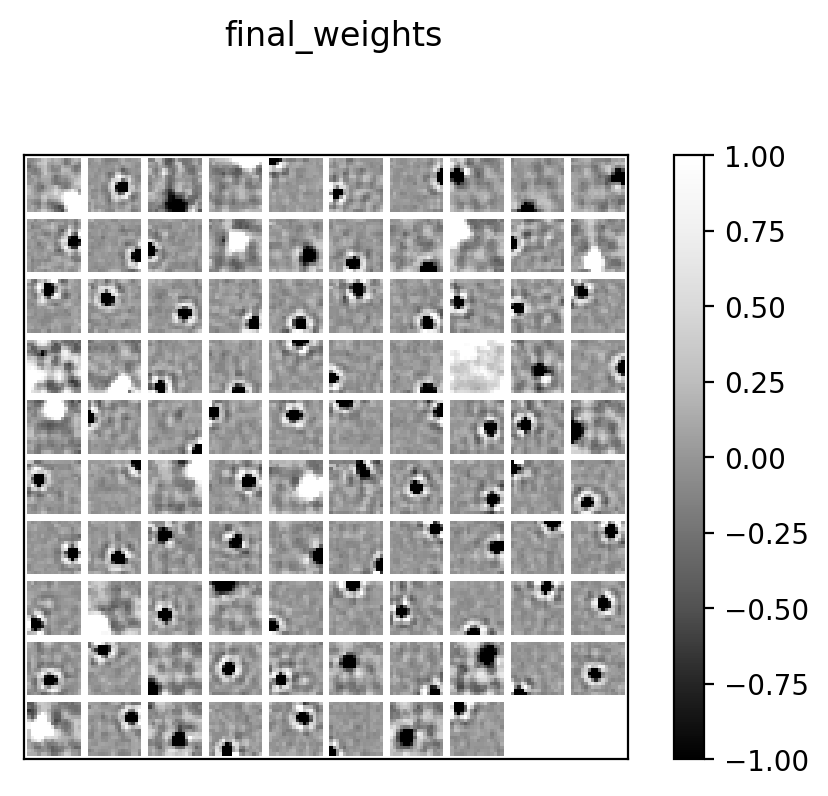

In [91]:
#Show our final weights
#wr = np.rollaxis(np.reshape(final_weights,(imxlen,imylen,nneurons)),2)
#im = plu.display_data_tiled(wr, normalize=False, title="final_weights", prev_fig=None)

#Show our final weights
weights_evolution_r = np.rollaxis(np.reshape(weights_evolution,(len(weights_evolution),imxlen,imylen,nneurons)),3,1)
(f,sa,ai) = plu.display_data_tiled(weights_evolution_r[-1], normalize=False, title="final_weights", prev_fig=None);
f.savefig(savefolder+'weights_final.png') 

In [86]:
print(savefolder)

c/actfun_sigmoid/neurons_98/noise_in_0_out_0_lambda_0/


In [ ]:
#save figures
if(0):
    for i in range(len(weights_evolution_r)):
        (f,sa,ai) = plu.display_data_tiled(weights_evolution_r[i], normalize=False,title="weights_evolving", prev_fig=None);
        f.savefig(savefolder+'/weights_evolution_'+str(i)+'.png'); 

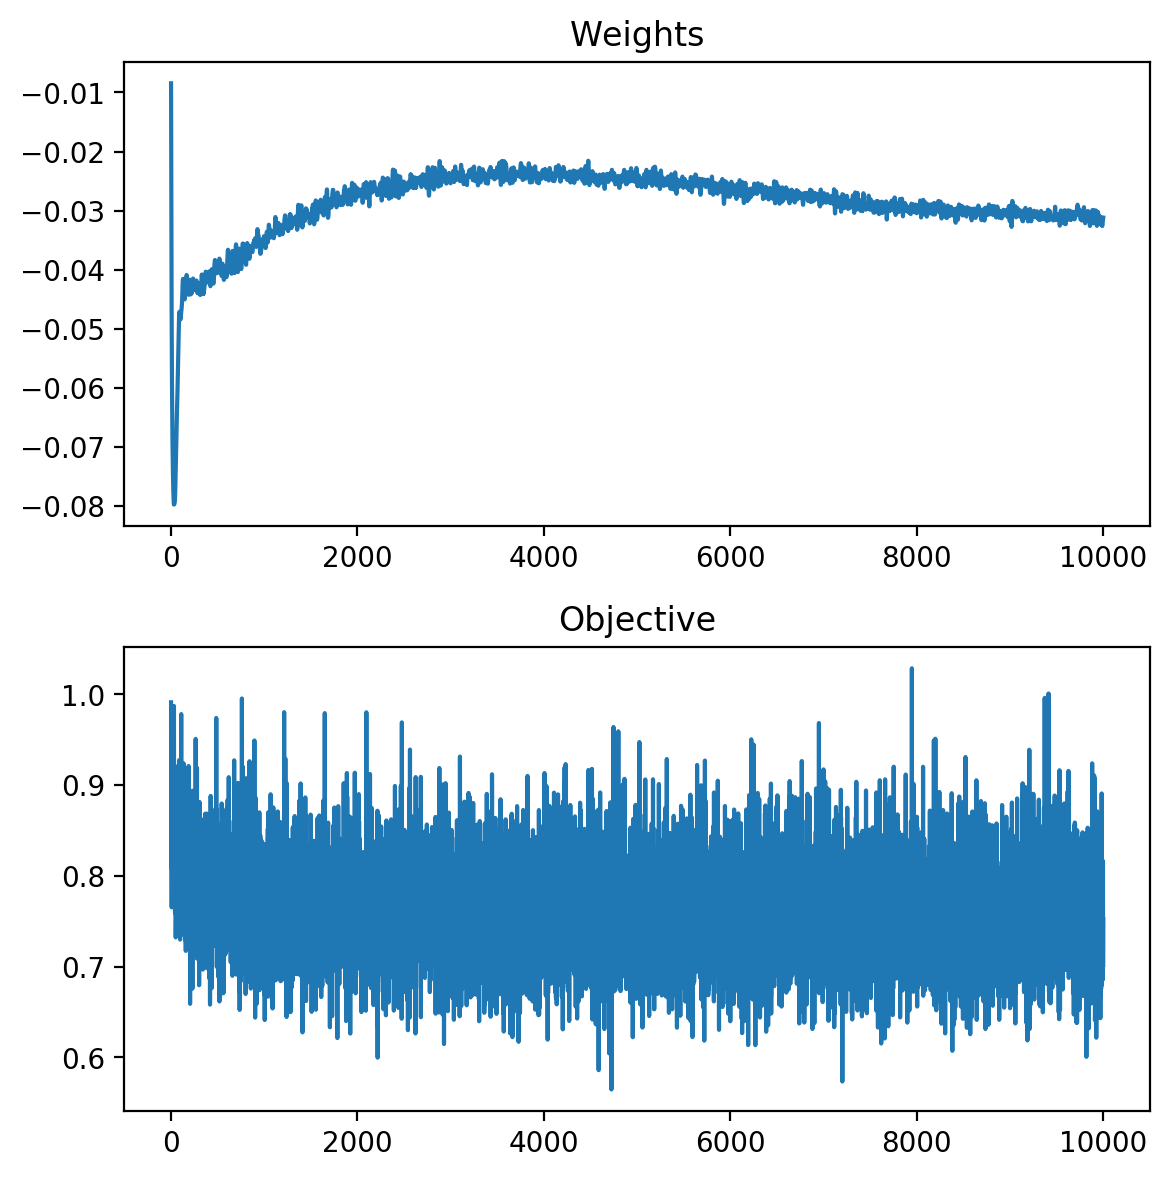

In [92]:
f2 = plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(wmean_evolution)

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

f2.savefig(savefolder+'/cost_weights.png') 

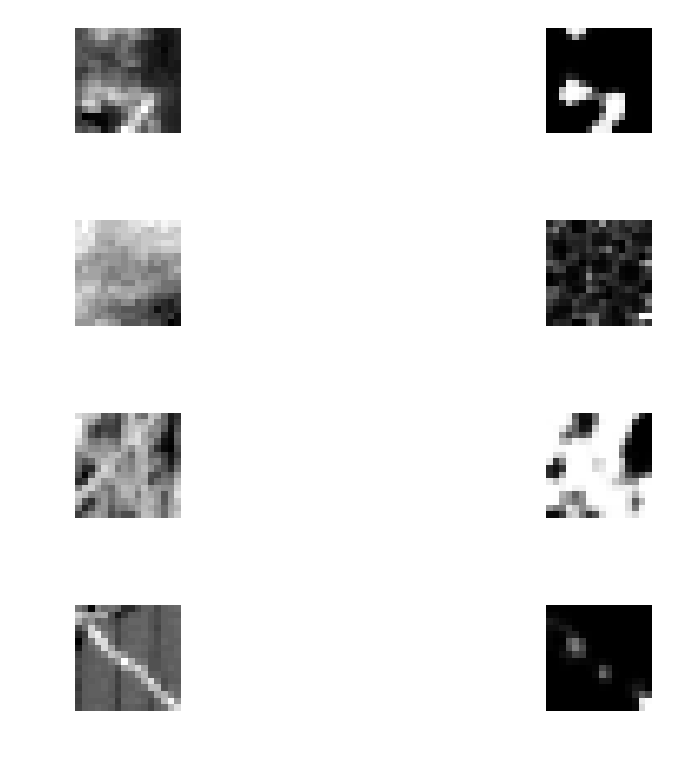

In [93]:
#show an example image and reconstruction from the last iteration of learning
patchnum = 3

plots = 4
for i in range(plots):
    plt.subplot(plots,2,2*i+1)#,title='Patch')
    plt.imshow(images[-1][patchnum+i],cmap='gray',interpolation='none')
    plt.axis('off')
    
    plt.subplot(plots,2,2*i+2)#,title='Recon')
    plt.imshow(recons[-1][patchnum+i],cmap='gray',interpolation='none')
    plt.axis('off')


plt.tight_layout()
plt.savefig(savefolder+'/reconstruction.png') 

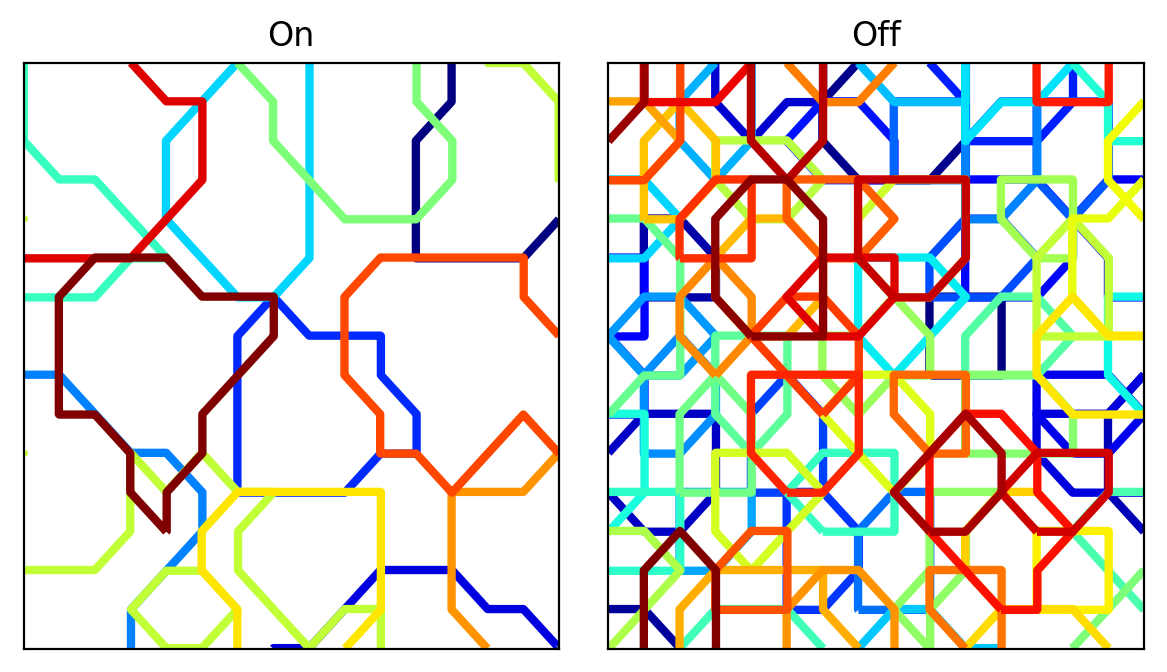

In [98]:
fig = plu.plotonoff(weights_evolution_r[-1]);
fig.savefig(savefolder+'/on_off_RFs.png') 

## Tensorboard Analysis

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [49]:
#show_graph(tf.get_default_graph().as_graph_def())